In [1]:
#IMPORT ALL THE REQUIRED LIBERARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Optional: for warnings suppression
import warnings
warnings.filterwarnings('ignore')

# Set visualizations inline
%matplotlib inline

In [2]:
# Load the dataset (Demographics)
datetimeevents = pd.read_csv('DATETIMEEVENTS.csv.gz')

# Preview the dataset
datetimeevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,711,7657,121183.0,297945.0,3411,2172-03-14 11:00:00,2172-03-14 11:52:00,16446,NaN,Date,NaN,NaN,NaN,NotStopd
1,712,7657,121183.0,297945.0,3411,2172-03-14 13:00:00,2172-03-14 12:36:00,16446,NaN,Date,NaN,NaN,NaN,NotStopd
2,713,7657,121183.0,297945.0,3411,2172-03-14 15:00:00,2172-03-14 15:10:00,14957,NaN,Date,NaN,NaN,NaN,NotStopd
3,714,7657,121183.0,297945.0,3411,2172-03-14 17:00:00,2172-03-14 17:01:00,16446,NaN,Date,NaN,NaN,NaN,NotStopd
4,715,7657,121183.0,297945.0,3411,2172-03-14 19:00:00,2172-03-14 19:29:00,14815,NaN,Date,NaN,NaN,NaN,NotStopd


In [3]:
# Step 3: Explore & clean
datetimeevents.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4485937 entries, 0 to 4485936
Data columns (total 14 columns):
 #   Column        Dtype  
---  ------        -----  
 0   ROW_ID        int64  
 1   SUBJECT_ID    int64  
 2   HADM_ID       float64
 3   ICUSTAY_ID    float64
 4   ITEMID        int64  
 5   CHARTTIME     object 
 6   STORETIME     object 
 7   CGID          int64  
 8   VALUE         object 
 9   VALUEUOM      object 
 10  WARNING       float64
 11  ERROR         float64
 12  RESULTSTATUS  float64
 13  STOPPED       object 
dtypes: float64(5), int64(4), object(5)
memory usage: 479.1+ MB


In [4]:
missing_values = datetimeevents.isnull().sum()
print(missing_values[missing_values > 0])

HADM_ID            1772
ICUSTAY_ID         4156
VALUE             52090
WARNING         1799017
ERROR           1799017
RESULTSTATUS    4485937
STOPPED         2686920
dtype: int64


In [5]:
# Drop duplicates 
datetimeevents.drop_duplicates(inplace=True)


In [6]:
#  Convert datetime columns
datetimeevents['CHARTTIME'] = pd.to_datetime(datetimeevents['CHARTTIME'], errors='coerce')


In [7]:
#  Encode categorical columns
cat_cols = ['VALUE', 'VALUEUOM']
for col in cat_cols:
    datetimeevents[col] = datetimeevents[col].astype('category').cat.codes


In [8]:
#  Scale numeric column if useful

from sklearn.preprocessing import MinMaxScaler

if 'ITEMID' in datetimeevents.columns:
    scaler = MinMaxScaler()
    datetimeevents['ITEMID_scaled'] = scaler.fit_transform(datetimeevents[['ITEMID']])


In [9]:
#  Save cleaned dataset
datetimeevents_cleaned = datetimeevents.copy()
datetimeevents_cleaned.to_csv('datetimeevents_cleaned.csv', index=False)



In [10]:
#  Create metadata
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(datetimeevents_cleaned)
metadata.update_column('CHARTTIME', sdtype='datetime', datetime_format='%Y-%m-%d %H:%M:%S')



In [11]:
#  Initialize synthesizer

from sdv.single_table import CTGANSynthesizer

synthesizer = CTGANSynthesizer(metadata=metadata, epochs=100)



In [12]:
#  Fit model (sample for speed)
datetimeevents_sample = datetimeevents_cleaned.sample(n=5000, random_state=42)
synthesizer.fit(datetimeevents_sample)



In [13]:
#  Sample synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv("synthetic_datetimeevents.csv", index=False)



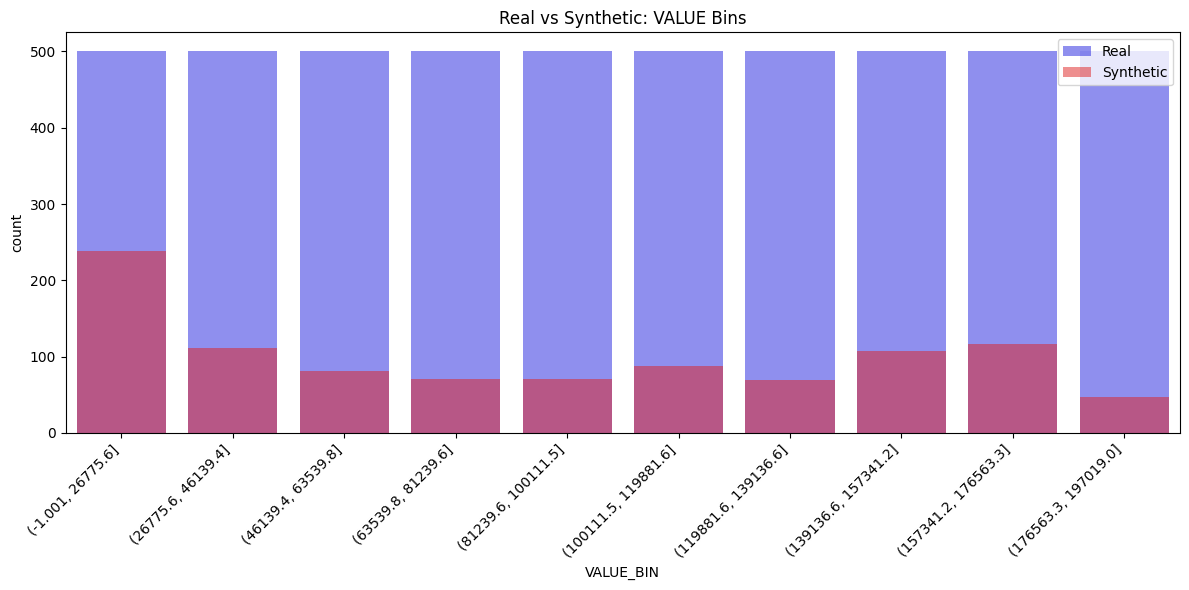

In [14]:
#  Compare distributions
# Create binned version
bins = pd.qcut(datetimeevents_sample['VALUE'], q=10, duplicates='drop')
datetimeevents_sample['VALUE_BIN'] = bins
synthetic_data['VALUE_BIN'] = pd.cut(synthetic_data['VALUE'], bins=bins.cat.categories)

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(x='VALUE_BIN', data=datetimeevents_sample, color='blue', label='Real', alpha=0.5)
sns.countplot(x='VALUE_BIN', data=synthetic_data, color='red', label='Synthetic', alpha=0.5)
plt.legend()
plt.title("Real vs Synthetic: VALUE Bins")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [15]:
#  Train & evaluate model (optional example)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

features = ['ITEMID', 'VALUE']
datetimeevents_sample['target'] = (datetimeevents_sample['VALUE'] > datetimeevents_sample['VALUE'].median()).astype(int)
synthetic_data['target'] = (synthetic_data['VALUE'] > datetimeevents_sample['VALUE'].median()).astype(int)

for col in features:
    datetimeevents_sample[col] = datetimeevents_sample[col].astype('category').cat.codes
    synthetic_data[col] = synthetic_data[col].astype('category').cat.codes

X_real = datetimeevents_sample[features]
y_real = datetimeevents_sample['target']
X_syn = synthetic_data[features]
y_syn = synthetic_data['target']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f"\n Model accuracy on real data:     {real_acc:.2f}")
print(f" Model accuracy on synthetic data: {syn_acc:.2f}")



 Model accuracy on real data:     1.00
 Model accuracy on synthetic data: 1.00


In [16]:
#  Import TVAESynthesizer
from sdv.single_table import TVAESynthesizer

#  Initialize VAE synthesizer
vae_synthesizer = TVAESynthesizer(
    metadata=metadata,
    epochs=30  # Same as CTGAN for fair comparison
)

#  Fit the VAE synthesizer
vae_synthesizer.fit(datetimeevents_sample.drop(columns=['VALUE_BIN', 'target']))

#  Sample synthetic data using VAE
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

#  Save VAE synthetic data
synthetic_data_vae.to_csv('synthetic_datetimeevents_vae.csv', index=False)

#  Preview VAE synthetic data
synthetic_data_vae.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED,ITEMID_scaled
0,16367966,57964,109331.0,283462.0,31,2104-02-28 16:56:08,2111-09-29 22:28:39,15002,535,0,0.0,0.0,NaN,NaN,0.981996
1,9373925,96673,171116.0,276656.0,36,2195-02-19 09:01:03,2189-10-23 13:57:40,14648,3442,0,0.0,0.0,NaN,NaN,0.985072
2,7756946,25799,109353.0,271183.0,30,2187-02-11 22:53:03,2191-11-09 15:26:15,15878,3988,0,0.0,0.0,NaN,NaN,0.982792
3,6016852,95097,114410.0,203992.0,35,2107-10-30 02:57:11,2103-06-30 06:56:06,14468,0,0,0.0,0.0,NaN,NaN,0.987569
4,14881709,84883,170938.0,267230.0,25,2198-08-28 18:47:18,2197-09-13 15:59:43,14480,4572,0,0.0,0.0,NaN,NaN,0.984831


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#  Define features
features = ['VALUE', 'ITEMID_scaled']  # Use the scaled and numerical columns

#  Create binary classification target using VALUE
median_val = datetimeevents_cleaned['VALUE'].median()
datetimeevents_cleaned['target'] = (datetimeevents_cleaned['VALUE'] > median_val).astype(int)
synthetic_data_vae['target'] = (synthetic_data_vae['VALUE'] > median_val).astype(int)

#  Encode categorical features if needed (not needed here since features are numeric)

#  Prepare X and y
X_real = datetimeevents_cleaned[features]
y_real = datetimeevents_cleaned['target']
X_vae = synthetic_data_vae[features]
y_vae = synthetic_data_vae['target']

#  Train/test split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

#  Train models
model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

#  Print comparison
print(f"Model accuracy on REAL DATETIMEEVENTS data:     {real_acc:.2f}")
print(f"Model accuracy on VAE SYNTHETIC DATETIMEEVENTS: {vae_acc:.2f}")


Model accuracy on REAL DATETIMEEVENTS data:     1.00
Model accuracy on VAE SYNTHETIC DATETIMEEVENTS: 1.00


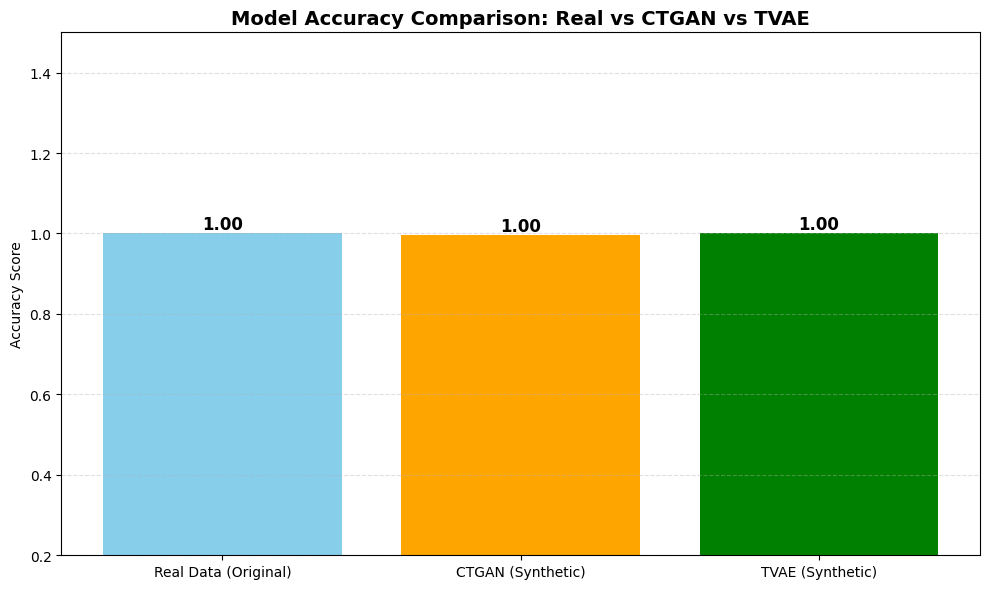

In [18]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
